In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import os
import cv2
import sys
import matplotlib.image as mpimg
from PIL import Image
import scipy
from scipy import ndimage
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse
import pickle
import numpy
from fastapi.responses import FileResponse

warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
# Load Logstic Model
filename = 'trained_logistic_reg_ridge_l2_norm_clf.sav'
trained_logistic_reg_ridge_l2_norm_clf = pickle.load(open("saved_model_weights/" + filename, 'rb'))

In [3]:
me = mpimg.imread("dataset/fixed_sized/me/IMG20200727112140.jpg")
image_0_1_vector = me.reshape(1, -1)/255
print(image_0_1_vector[:5])
print(image_0_1_vector.shape)
trained_logistic_reg_ridge_l2_norm_clf.predict(image_0_1_vector)

[[0.61568627 0.65882353 0.38823529 ... 0.42352941 0.48235294 0.56470588]]
(1, 30000)


array([1])

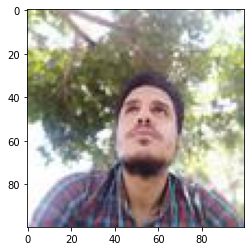

In [4]:
plt.imshow(me)

In [5]:
other = mpimg.imread("dataset/fixed_sized/other/FB_IMG_1443137065411.jpg")
image_0_1_vector = other.reshape(1, -1)/255
print(image_0_1_vector.shape)
trained_logistic_reg_ridge_l2_norm_clf.predict(image_0_1_vector)

(1, 30000)


array([0])

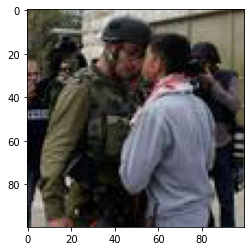

In [6]:
plt.imshow(other)

In [7]:
SAVE_DIR = "images_uploaded/"
resized_images = "resized_images/"
write_on_images = "write_on_images/"

resize_width,resize_height = 100, 100 
image_features  = resize_width * resize_height * 3 

In [8]:

app = FastAPI(title='Deploying a ML Model with FastAPI')


class Model(str, Enum):
    Logistic_Regression = "Logistic_Regression"
    Shallow_NN          = "Shallow_NN"
    Deep_NN             = "Deep_NN"



@app.get("/")
def home():
    return "Congratulations! Your API is working as expected. Now head over to http://localhost:5007/docs."


@app.post("/predict_me") 
async def prediction(model: Model, file: UploadFile = File(...)):

    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png", "JPG", "JPEG", "PNG")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
        
    contents = await file.read() 
    # example of how you can save the file
    with open(f"{SAVE_DIR}{file.filename}", "wb") as f:
        f.write(contents)
    #    
    
    img = Image.open(f"{SAVE_DIR}{file.filename}")
    img = img.resize((resize_width, resize_width), Image.ANTIALIAS)
    
    img.save(SAVE_DIR + resized_images  +   file.filename)
    
    predict_image = mpimg.imread(f"{SAVE_DIR}{resized_images}{file.filename}")
    image_0_1_vector = predict_image.reshape(-1, 1)/255
    
    my_predicted_image = trained_logistic_reg_ridge_l2_norm_clf.predict(image_0_1_vector.T)
    print(my_predicted_image)
    my_predicted_image = ["Me WOW :)!!!!!!!!" if my_predicted_image==1 else "Not Me:("][0]
    print(my_predicted_image)
    file_image = cv2.imread(f'images_uploaded/{filename}', cv2.IMREAD_UNCHANGED)
    
    cv2.putText(file_image, my_predicted_image, (10,200), cv2.FONT_HERSHEY_COMPLEX_SMALL, 6,  (170,125, 145, 120), 5)
    
    
    cv2.imwrite(f'images_uploaded/{write_on_images}{filename}', file_image)
    
    # Return the image as a stream specifying media type
    return FileResponse(f'images_uploaded/{write_on_images}{filename}')

In [ ]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# Host depends on the setup you selected (docker or virtual env)
host = "0.0.0.0" if os.getenv("DOCKER-SETUP") else "127.0.0.1"

# Spin up the server!    
uvicorn.run(app, host=host, port=5007)

INFO:     Started server process [6320]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:5007 (Press CTRL+C to quit)


INFO:     127.0.0.1:41854 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:41854 - "GET /openapi.json HTTP/1.1" 200 OK
[0]
Not Me:(
INFO:     127.0.0.1:41858 - "POST /predict_me?model=Logistic_Regression HTTP/1.1" 200 OK
INFO:     127.0.0.1:41866 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:41866 - "GET /openapi.json HTTP/1.1" 200 OK
[0]
Not Me:(
INFO:     127.0.0.1:41870 - "POST /predict_me?model=Logistic_Regression HTTP/1.1" 200 OK
[0]
Not Me:(
INFO:     127.0.0.1:41876 - "POST /predict_me?model=Logistic_Regression HTTP/1.1" 200 OK
[0]
Not Me:(
INFO:     127.0.0.1:41880 - "POST /predict_me?model=Logistic_Regression HTTP/1.1" 200 OK
[1]
Me WOW :)!!!!!!!!
INFO:     127.0.0.1:41884 - "POST /predict_me?model=Logistic_Regression HTTP/1.1" 200 OK
[0]
Not Me:(
INFO:     127.0.0.1:41888 - "POST /predict_me?model=Logistic_Regression HTTP/1.1" 200 OK
[0]
Not Me:(
INFO:     127.0.0.1:41892 - "POST /predict_me?model=Logistic_Regression HTTP/1.1" 200 OK
[0]
Not Me:(
INFO:     127.0.0.1:4189